# CIELAB and RGB values for colors
|               |          _CIELAB_         |      _RGB_      |           |          _CIELAB_         |      _RGB_     |
|---------------|:-------------------------:|:---------------:|:---------:|:-------------------------:|:--------------:|
| **Arancione** |  (74.936, 23.933, 78.95)  |  (255, 165, 0)  |  **Nero** |         (0, 0, 0)         |   (0 ,0 , 0)   |
| **Bianco**    |        (100, 0, 0)        | (255, 255, 255) | **Rosso** |  (53.241, 80.092, 67.203) |   (255, 0, 0)  |
| **Blu**       | (32.297, 79.188, -107.86) |   (0, 0, 255)   | **Verde** | (87.735, -86.183, 83.179) |   (0, 255, 0)  |
| **Giallo**    | (97.139, -21.554, 94.478) |  (255, 255, 0)  | **Viola** | (45.357, 78.735, -77.393) | (160, 32, 240) |

Generation of the ground truth color

In [1]:
COLOR_LIST = {"arancione": (255, 165, 0),
        "bianco": (255, 255, 255), 
        "blu": (0, 0, 255), 
        "giallo": (255, 255, 0), 
        "nero": (0, 0, 0), 
        "rosso": (255, 0, 0), 
        "verde": (0, 255, 0), 
        "viola": (160, 32, 240), 
    }

In [16]:
from skimage.color import deltaE_ciede2000, rgb2lab
from skimage.io import imread, imsave
import numpy as np


def loadAndConvert2LAB(path):
    return rgb2lab(imread(path)).astype(np.float32)


def getGroudTruthImage(width, height, channels, path = None):
    # RGB values for pure colors
    global COLOR_LIST

    imgs = {}
    for name, color_value in COLOR_LIST.items():
        img = np.zeros((height, width, channels), np.uint8)
        img[:,:] = color_value

        imgs[name] = img

        if path is not None:
            imsave("/".join((path, f"{name}_RGB.png")), img)
    
    return imgs

## Transform all the dataset Image from RGB space to LAB space
The lab space can be used to mesure the distance between two image in a way that too near images are also perceptually similar.
This distance is intended to be used as an eucledian distance

In [2]:
import json, numpy as np
import os
from skimage.io import imread
from skimage.color import rgb2lab
from tqdm import tqdm

ROOT_PATH = '/home/ilchrees/data/gitRepo/Thesis/Datasets'

DATASET_PATH = ROOT_PATH + "/wikiart"
METADATA_PATH = DATASET_PATH + "/dataset.json"
LABEL_MAPPING_PATH = "/home/ilchrees/data/gitRepo/Thesis/dataset_preprocessing/mapping.json"

IMAGE_COORDINATES_PATH = "/home/ilchrees/data/gitRepo/Thesis/dataset_preprocessing/image_coordinates.npy"

with open(METADATA_PATH, "r") as metadata_file:
    metadata = json.load(metadata_file)["labels"]

with open(LABEL_MAPPING_PATH, "r") as label_mapping_file:
    label_mapping = {letteral: numerical for letteral, numerical in json.load(label_mapping_file)}
    label_mapping_r = {numerical:letteral for letteral, numerical in label_mapping.items()}

Compute the mean point in the LAB space. IT TAKES 5 HOURS

In [ ]:
n_images = None
image_3D_coordinate = {}
iterator = tqdm(metadata[:n_images])
for image_path, numerical_label in iterator:
    letteral_label = label_mapping_r[numerical_label]
    
    img_coord = rgb2lab(imread(os.path.join(DATASET_PATH, image_path))).mean((0,1))
    
    iterator.set_description((
                f"Processing image: {image_path}, label: {letteral_label}, Coordinates: {img_coord}"
            ))
    
    image_3D_coordinate[image_path] = { letteral_label:img_coord }

# Save the data in a file so it can be loaded
with open(IMAGE_COORDINATES_PATH, "wb") as fout:
    np.save(file=fout, 
            arr=image_3D_coordinate, 
            allow_pickle=True)


Load data for the transformed images in LAB color-space

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams.update({'font.size': 22})

np.random.seed(5)
with open(IMAGE_COORDINATES_PATH, "rb") as fin:
    image_3D_coordinate_loaded = np.load(fin, allow_pickle=True).item()

X = np.array([img_coord for v in image_3D_coordinate_loaded.values() for img_coord in v.values()])
y = [label_mapping[img_label] for v in image_3D_coordinate_loaded.values() for img_label in v.keys()]

Use the K-means balanced clustering in the LAB color space.

This k-means generate clusters with the same number of sample insinde each cluster.

In [31]:
from k_means_constrained import KMeansConstrained

n_clusters = 8
n_sample = len(y)
size_max = np.ceil(n_sample / n_clusters)
size_min = int(size_max - 0.1 * size_max)

estimators = [
    KMeansConstrained(
                n_clusters=n_clusters,
                size_min=size_min,
                size_max=size_max,
                random_state=0,
                n_jobs=6,
                ),
            ]

for clf in estimators:
    clf.fit_predict(X)
    labels = clf.labels_

('Number of elements per Cluster: Counter({7: 2472, 4: 2472, 2: 2472, 1: 2472, '
 '5: 2472, 0: 2472, 6: 2472, 3: 2470})\n')


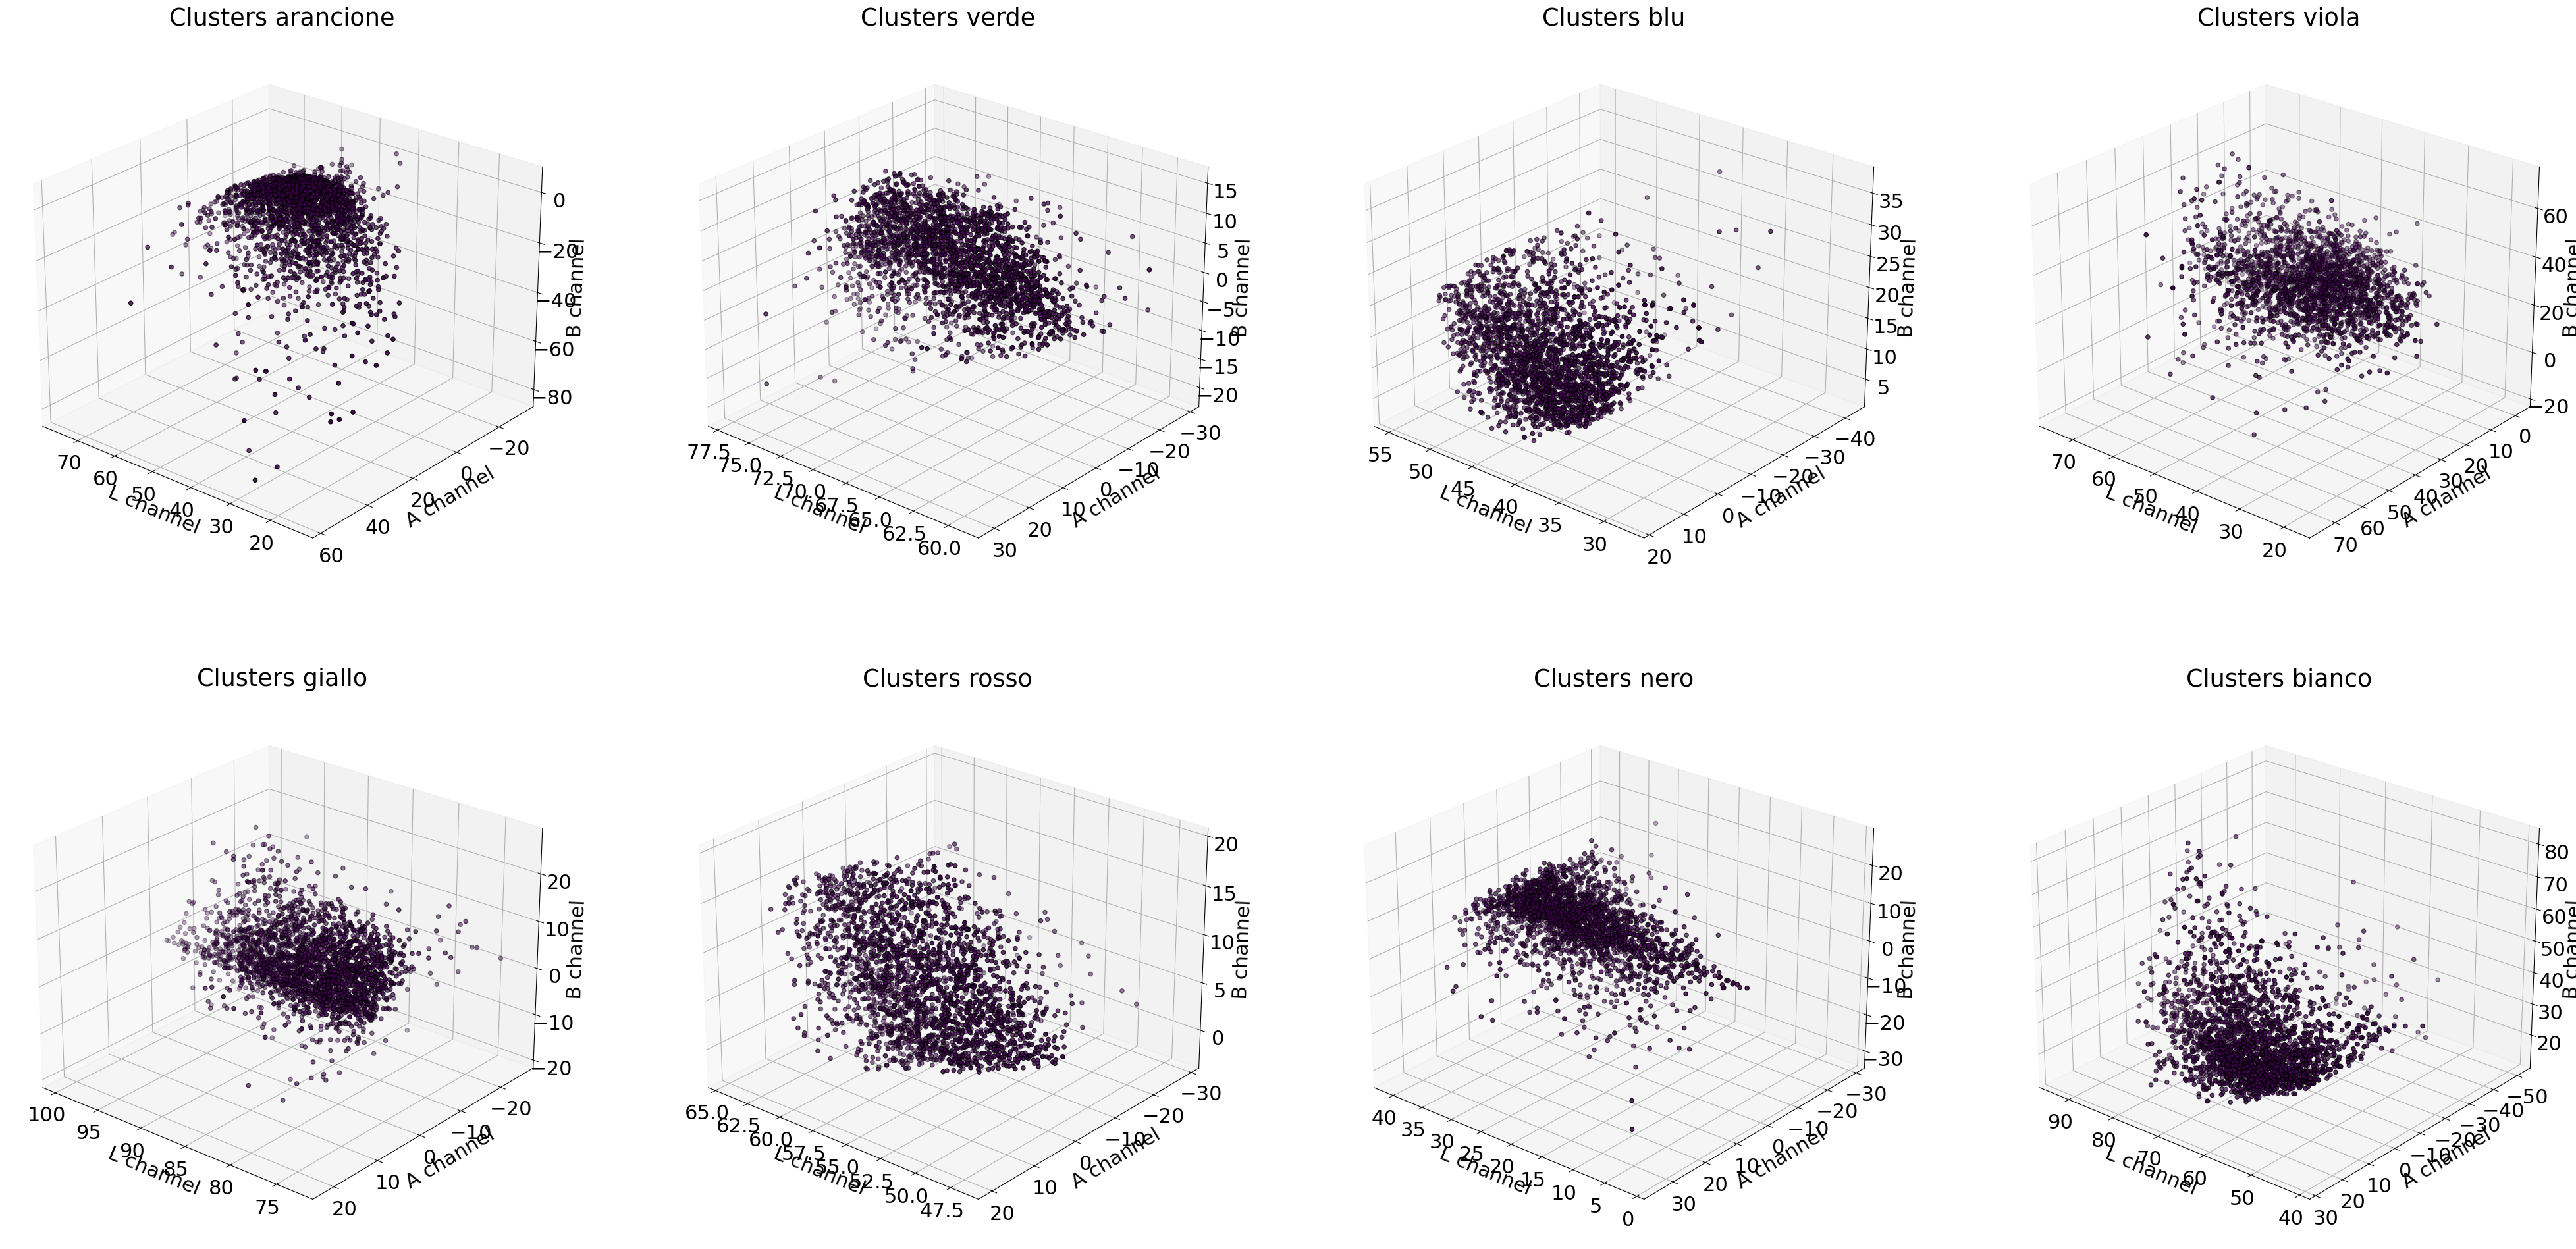

In [32]:
from pprint import pprint

fig = plt.figure(figsize=(50, 50))
for cluster in range(n_clusters):
    elment_boolean_mask = labels==cluster
    subset_x = X[elment_boolean_mask, :]

    ax = fig.add_subplot(4, 4, cluster + 1, projection="3d", elev=25, azim=130)

    ax.scatter(subset_x[:, 0], subset_x[:, 1], subset_x[:, 2], c=labels[elment_boolean_mask].astype(float), edgecolor="k")

    ax.set_xlabel("L channel")
    ax.set_ylabel("A channel")
    ax.set_zlabel("B channel")
    ax.set_title(f"Clusters {label_mapping_r[cluster]}")

# print(clf.cluster_centers_)
pprint(f"Number of elements per Cluster: {Counter(clf.labels_)}\n", indent=4)

Ground truth cluster visualization

Ground truth label number: Counter({7: 5889, 3: 4098, 6: 3531, 0: 2586, 1: 2493, 5: 647, 2: 388, 4: 142})



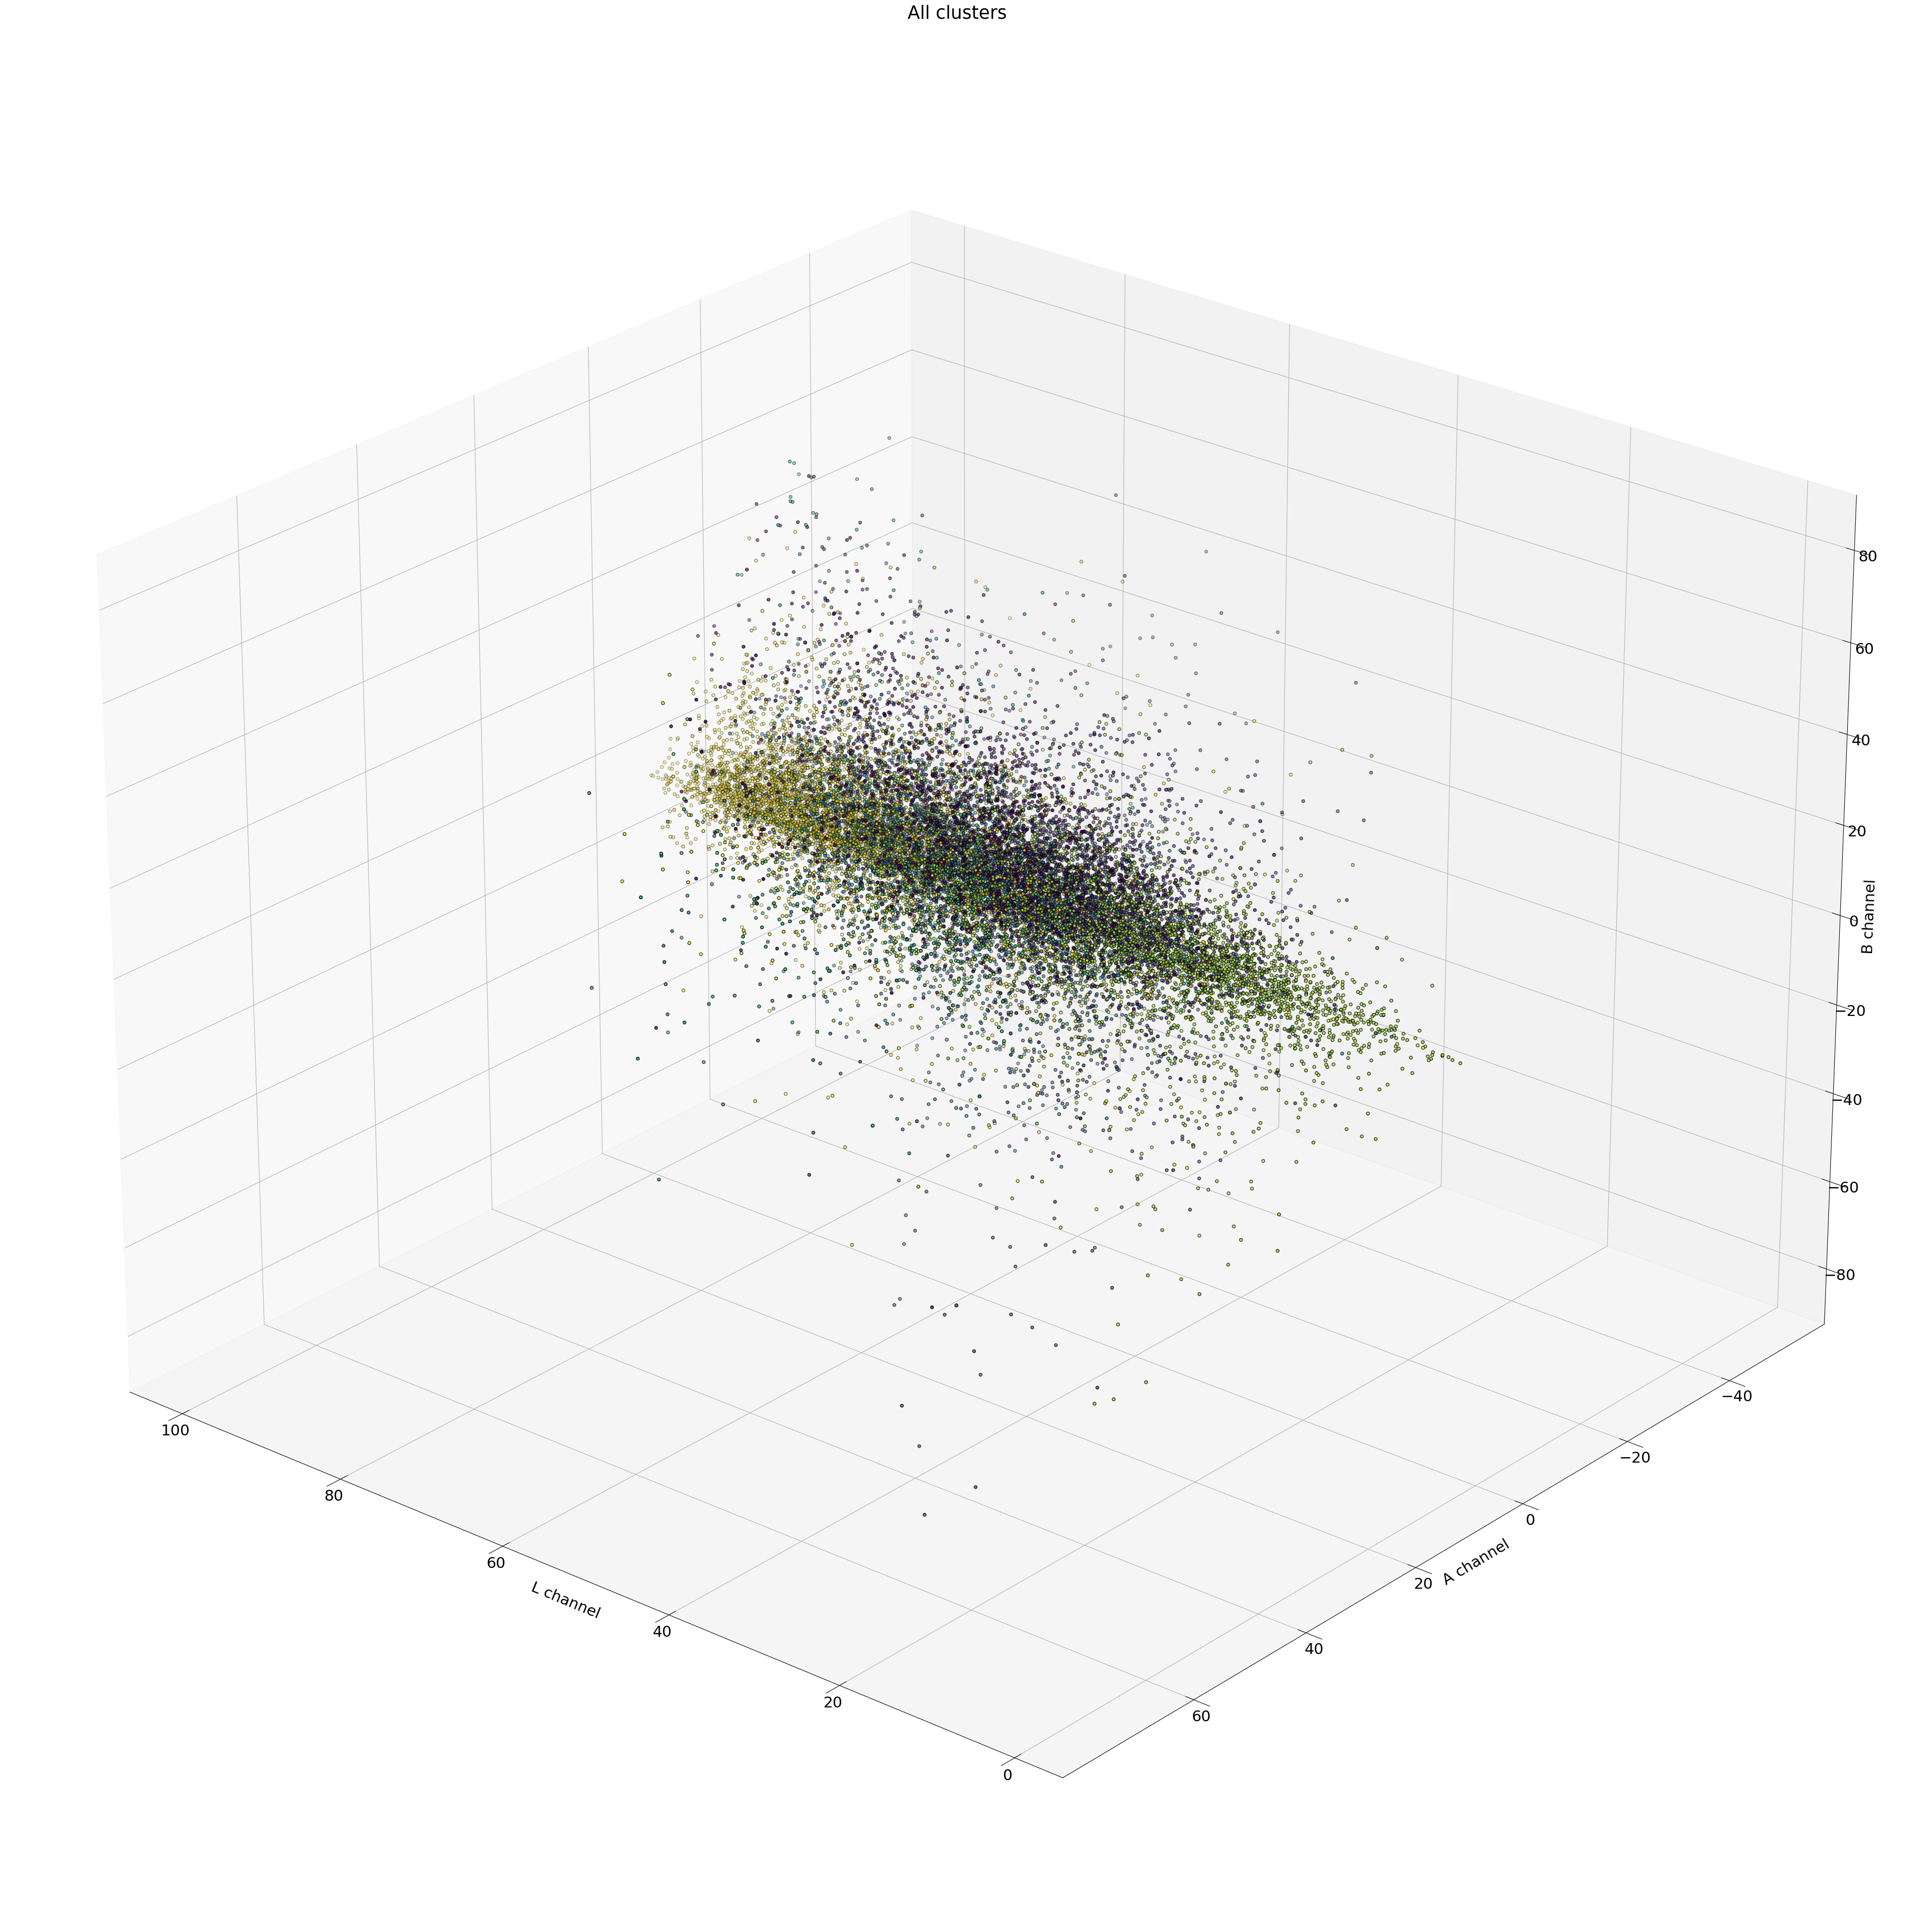

In [33]:
fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(1, 1, 1, projection="3d", elev=25, azim=130)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.array(y).astype(float), edgecolor="k")

ax.set_xlabel("L channel")
ax.set_ylabel("A channel")
ax.set_zlabel("B channel")
ax.set_title(f"All clusters")

print(f"Ground truth label number: {Counter(y)}\n")

### Use a custom metric to compute the clustering

K-medoids with custom similaruty function

https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html

In [25]:
from sklearn_extra.cluster import KMedoids
import numpy as np


def delta2000ColorDifference(p1:np.array, p2:np.array):
    return deltaE_ciede2000(p1, p2)

scenters = np.array([rgb2lab(v).mean((0,1)) for v in getGroudTruthImage(512, 512, 3).values()])

kmedoids = KMedoids(n_clusters=8, 
                    metric=delta2000ColorDifference,
                    method='alternate',
                    init="k-medoids++",
                    random_state=0)
kmedoids.fit(X)

print(kmedoids.labels_)
print(kmedoids.cluster_centers_)

KeyboardInterrupt: 

K-means With custom distance function

In [ ]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from skimage.color import deltaE_ciede2000, rgb2lab

def delta2000ColorDifference(p1:np.array, p2:np.array):
    return deltaE_ciede2000(p1, p2)

metric = distance_metric(type_metric.USER_DEFINED, func=delta2000ColorDifference)

scenters = [rgb2lab(v).mean((0,1)) for v in getGroudTruthImage(512, 512, 3).values()]

kinstance = kmeans(X, initial_centers=scenters, metric=metric)

kinstance.process()

clstr = kinstance.get_clusters()

In [ ]:
from scipy.cluster.hierarchy import fclusterdata
import numpy as np
from skimage.color import deltaE_ciede2000


def delta2000ColorDifference(p1:np.array, p2:np.array):
    return deltaE_ciede2000(p1, p2)


fcluster = fclusterdata(X, t=1, metric=delta2000ColorDifference)

## Re-subdivision of the dataset

In [ ]:
from tqdm import tqdm
import cv2
from albumentations.augmentations.geometric.resize import Resize

src_dir = "/home/ilchrees/data/gitRepo/Thesis/Datasets/wikiart"
dest_dir = "/home/ilchrees/data/gitRepo/Thesis/Datasets/wikiart_new_subdivision_256"
resize_transform = Resize(height=256, width=256,always_apply=True)

for image_path, numerical_label in tqdm(metadata[:None]):
    letteral_label = label_mapping_r[numerical_label]
    image_name = image_path.split("/")[-1]

    image = cv2.imread(src_dir + f"/{image_path}")
    image_cvt = resize_transform(image=image)["image"]

    if not os.path.exists(dest_dir + f"/{letteral_label}"):
        os.makedirs(dest_dir + f"/{letteral_label}")
    
    cv2.imwrite(dest_dir + f"/{letteral_label}/{image_name}", image_cvt)

In [15]:
import shutil
from tqdm import tqdm

dest_dir = "/home/ilchrees/data/gitRepo/Thesis/Datasets/wikiart_new_subdivision"
src_dir = "/home/ilchrees/data/gitRepo/Thesis/Datasets/wikiart"

n_images = None
iterator = tqdm(zip(image_3D_coordinate_loaded.keys(), clf.labels_))

for image_path, numerical_label in iterator:
    letteral_label = label_mapping_r[numerical_label]
    
    if not os.path.exists(dest_dir + f"/{letteral_label}"):
        os.makedirs(dest_dir + f"/{letteral_label}")

    shutil.copy(src_dir + f"/{image_path}", dest_dir + f"/{letteral_label}")

19774it [01:00, 328.64it/s]
